In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast

In [23]:
tower = np.load('data/The Eiffel Tower.npy')
clock = np.load('data/alarm clock.npy')
apple = np.load('data/apple.npy')
axe = np.load('data/axe.npy')
bandage = np.load('data/bandage.npy')
basketball = np.load('data/basketball.npy')
bed = np.load('data/bed.npy')
bird = np.load('data/bird.npy')
bowtie = np.load('data/bowtie.npy')
bread = np.load('data/bread.npy')

tower = tower[:1000, :]
clock = clock[:1000, :]
apple = apple[:1000, :]
axe = axe[:1000, :]
bandage = bandage[:1000, :]
basketball = basketball[:1000, :]
bed = bed[:1000, :]
bird = bird[:1000, :]
bowtie = bowtie[:1000, :]
bread = bread[:1000, :]

labels = ['tower', 'clock', 'apple', 'axe', 'bandage', 'basketball', 'bed', 'bird', 'bowtie', 'bread']
label_arrs = [tower, clock, apple, axe, bandage, basketball, bed, bird, bowtie, bread]
datapts = []

encoding = {'tower': 0, 
            'clock': 1, 
            'apple': 2, 
            'axe': 3,
            'bandage': 4,
            'basketball': 5,
            'bed': 6,
            'bird': 7,
            'bowtie': 8, 
            'bread': 9}

for label, arr in zip(labels, label_arrs):
    for row in arr:
        datapts.append({'image': row, 'label': label})

all_data = pd.DataFrame(datapts)
all_data['label'] = all_data['label'].apply(lambda x : encoding[x])

In [63]:
#dataset = 
#load dataset into dataloader, etc

class SketchDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.reset_index(drop=True)  # Reset indices to ensure contiguity
        self.images, self.labels = self.dataframe['image'], self.dataframe['label']
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img = self.images[idx]
        img = img.reshape((28,28))
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        img_tensor = torch.tensor(img, dtype=torch.float32)
            
        return img_tensor, label_tensor

# Assuming you have defined your DataFrame 'all_data' somewhere
shuffled_df = all_data.sample(frac=1, random_state=42)

total_rows = len(shuffled_df)
train_rows = int(0.7 * total_rows)
val_rows = int(0.1 * total_rows)

train_df = shuffled_df[:train_rows]
val_df = shuffled_df[train_rows:train_rows + val_rows]
test_df = shuffled_df[train_rows + val_rows:]

batch_size = 50

train_dataset = SketchDataset(train_df)
val_dataset = SketchDataset(val_df)
test_dataset = SketchDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size)
val_dataloader = DataLoader(val_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)


In [57]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        #goal: simplified Alexnet architecture
        #input: 28x28x1 image, grayscaled
        #first idea: 3 conv-relu-pool layers, followed by 2 fc layers and softmax non-linearity

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, 3, 1, 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(10, 20, 3, 1, 'same'),
            nn.MaxPool2d(2, 2)
        )
        
        

        self.linear_layers = nn.Sequential(
            nn.Linear(980, 980),
            nn.ReLU(),
            nn.Dropout(p = .2),
            nn.Linear(980, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim = 1)
        return self.linear_layers(x)
#model = ImageClassifier()
#inputs, outputs = next(iter(train_dataloader))
#inputs = torch.reshape(inputs, (batch_size, 1, 28, 28))
#model.forward(inputs)

In [62]:
lr = .00015
epochs = 30

model = ImageClassifier()
optim = torch.optim.Adam(model.parameters(), lr, weight_decay = .15)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma = .8)
loss_function = nn.CrossEntropyLoss()
train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch in range(epochs):
    train_acc = 0.
    val_acc = 0.
    train_loss = []
    val_loss = []
    
    model.train()
    for idx, batch in enumerate(train_dataloader):
        optim.zero_grad()
        inputs, labels = batch
        inputs = torch.reshape(inputs, (batch_size, 1, 28, 28))
        outputs = model.forward(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        prediction = torch.argmax(outputs, dim=1)
        batch_acc = (prediction == labels).sum().item()
        train_acc += batch_acc
    scheduler.step()
    
    model.eval()  
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():  
            inputs, labels = batch
            inputs = torch.reshape(inputs, (batch_size, 1, 28, 28))
            outputs = model.forward(inputs)
            loss = loss_function(outputs, labels)
            val_loss.append(loss.item())
            prediction = torch.argmax(outputs, dim=1)
            batch_acc = (prediction == labels).sum().item()
            val_acc += batch_acc
    train_acc /= len(train_dataloader.dataset)
    val_acc /= len(val_dataloader.dataset)
    print("Epoch:", epoch, "Train Loss:", np.mean(train_loss), "Train Acc:", train_acc, "Val Loss:", np.mean(val_loss), "Val Acc:", val_acc)
    train_loss_per_epoch.append(np.mean(train_loss))
    val_loss_per_epoch.append(np.mean(val_loss))
    


Epoch: 0 Train Loss: 2.9187218887465343 Train Acc: 0.6532857142857142 Val Loss: 1.004632183909416 Val Acc: 0.788
Epoch: 1 Train Loss: 0.7978791478489127 Train Acc: 0.7981428571428572 Val Loss: 0.6705158889293671 Val Acc: 0.831
Epoch: 2 Train Loss: 0.4903054012783936 Train Acc: 0.8477142857142858 Val Loss: 0.6026101648807526 Val Acc: 0.843
Epoch: 3 Train Loss: 0.359124400892428 Train Acc: 0.8825714285714286 Val Loss: 0.5897863924503326 Val Acc: 0.835
Epoch: 4 Train Loss: 0.2821514992841652 Train Acc: 0.909 Val Loss: 0.5763506844639779 Val Acc: 0.838
Epoch: 5 Train Loss: 0.2438152644251074 Train Acc: 0.9244285714285714 Val Loss: 0.5517127394676209 Val Acc: 0.844
Epoch: 6 Train Loss: 0.20983021589262144 Train Acc: 0.9324285714285714 Val Loss: 0.5607997715473175 Val Acc: 0.84
Epoch: 7 Train Loss: 0.185192919416087 Train Acc: 0.9471428571428572 Val Loss: 0.5310212254524231 Val Acc: 0.853
Epoch: 8 Train Loss: 0.17455645174320256 Train Acc: 0.9477142857142857 Val Loss: 0.5303188629448414 Val 

In [65]:
#evaluate on test set !!!
for epoch in range(epochs):
    correct = 0
    
    model.eval()  
    for idx, batch in enumerate(test_dataloader):
        with torch.no_grad():  
            inputs, labels = batch
            inputs = torch.reshape(inputs, (batch_size, 1, 28, 28))
            outputs = model.forward(inputs)
            prediction = torch.argmax(outputs, dim=1)
            batch_correct = (prediction == labels).sum().item()
            correct += batch_correct
print("Accuracy:", correct/len(test_dataloader.dataset))

Accuracy: 0.868


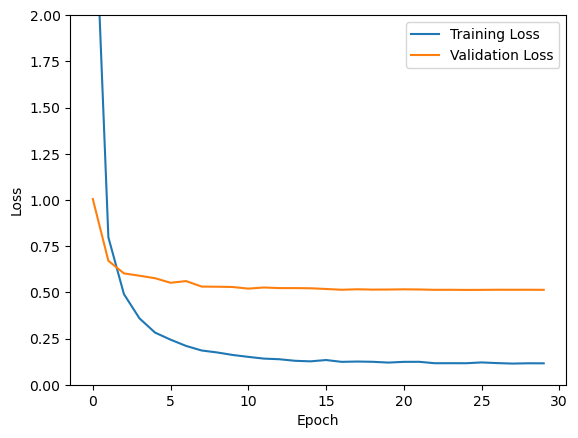

In [66]:
plt.plot(train_loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()

plt.show()
